In [ ]:
%pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.1 MB/s eta 0:00:00


In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

import xgboost as xgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # supress rdkit warnings
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

D:\Chem_conditions\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# df = pd.read_csv('/content/drive/MyDrive/AI-based planning of organic synthesis [data]/reactions_datasets/dataset_smiles_descriptors.tsv', sep="\t")
df = pd.read_csv('../data/interim/dataset_smiles_descriptors.tsv', sep="\t")

C:\Users\nikit\AppData\Local\Temp\ipykernel_23148\3850553142.py:2: DtypeWarning: Columns (5,6,10,11,12,24,31,34,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/interim/dataset_smiles_descriptors.tsv', sep="\t")


In [9]:
def get_fingerprint(x, nBits):
    fp_array = np.zeros((0,), dtype=np.int8)
    if x is not None and type(x) != float:
        mol = Chem.MolFromSmiles(x)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits) 
        ConvertToNumpyArray(fp, fp_array)
        return fp_array
    else:
        return np.zeros((nBits,), dtype=np.int8)

In [10]:
def get_yield_class(y):
  if y <= 33:
    c = 0 #low
  elif y >= 34 and y <= 66:
    c = 1 #medium
  elif y >= 67:
    c = 2 #high
  return c

In [11]:
df_new = pd.DataFrame()

In [12]:
df_new['yield_value'] = df['yield_value'].apply(get_yield_class).to_frame().set_index(df.index)

In [13]:
df_new['product'] = df['products_smiles'].apply(get_fingerprint, nBits=512).to_frame().set_index(df.index)

In [14]:
df_new['reactants_I'] = df['reactants_smiles'].apply(get_fingerprint, nBits=128).to_frame().set_index(df.index)

In [15]:
df_new['reactants_II'] = df['reactants_II_smiles'].apply(get_fingerprint, nBits=128).to_frame().set_index(df.index)

In [16]:
df_new['reaction'] = df_new[['reactants_I', 'reactants_II', 'product']].apply(np.concatenate, axis=1)
reactions_fp = pd.DataFrame(df_new.loc[:, 'reaction'].values.tolist())

In [17]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(reactions_fp, df_new['yield_value'], test_size=0.25, random_state=42, shuffle=True)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_3, y_train_3, test_size=0.25, random_state=42, shuffle=True)

In [23]:
def objective(trial):
    """Define the objective function"""

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**param)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    return f1_score(y_val, y_pred, average='weighted')

In [25]:
study_class = optuna.create_study(direction="maximize", study_name='classification')
study_class.optimize(objective, n_trials=30)

[I 2023-04-04 13:53:03,948] A new study created in memory with name: classification
[I 2023-04-04 13:55:35,217] Trial 0 finished with value: 0.6855254711065164 and parameters: {'max_depth': 8, 'learning_rate': 0.1252060985936404, 'n_estimators': 263, 'min_child_weight': 10, 'gamma': 0.2332778145845138, 'subsample': 0.8593097182608037, 'colsample_bytree': 0.6916310065584576, 'reg_alpha': 0.4999304315150876, 'reg_lambda': 0.35333262821854994, 'random_state': 819}. Best is trial 0 with value: 0.6855254711065164.
[I 2023-04-04 13:55:52,395] Trial 1 finished with value: 0.6385853934863005 and parameters: {'max_depth': 1, 'learning_rate': 0.8440956249293357, 'n_estimators': 246, 'min_child_weight': 6, 'gamma': 0.15814862509847807, 'subsample': 0.7810039095186193, 'colsample_bytree': 0.2007057263766329, 'reg_alpha': 0.3438208114583717, 'reg_lambda': 0.9337303677125092, 'random_state': 961}. Best is trial 0 with value: 0.6855254711065164.
[I 2023-04-04 13:58:04,627] Trial 2 finished with value

[I 2023-04-04 14:37:34,207] Trial 19 finished with value: 0.7082438191256909 and parameters: {'max_depth': 9, 'learning_rate': 0.48057799741324897, 'n_estimators': 354, 'min_child_weight': 3, 'gamma': 0.38410843210768003, 'subsample': 0.6833053993753271, 'colsample_bytree': 0.49783030716594706, 'reg_alpha': 0.23280642866925055, 'reg_lambda': 0.5959510590732177, 'random_state': 560}. Best is trial 19 with value: 0.7082438191256909.
[I 2023-04-04 14:41:05,990] Trial 20 finished with value: 0.6966356669886751 and parameters: {'max_depth': 9, 'learning_rate': 0.9757736448913283, 'n_estimators': 359, 'min_child_weight': 5, 'gamma': 0.3743630771245051, 'subsample': 0.6896360889051733, 'colsample_bytree': 0.54062884199514, 'reg_alpha': 0.26239791249634126, 'reg_lambda': 0.5607660314252046, 'random_state': 276}. Best is trial 19 with value: 0.7082438191256909.
[I 2023-04-04 14:41:27,599] Trial 21 finished with value: 0.6884820898684416 and parameters: {'max_depth': 9, 'learning_rate': 0.490015

In [26]:
study_class.best_params

{'max_depth': 9,
 'learning_rate': 0.2894189303719569,
 'n_estimators': 483,
 'min_child_weight': 4,
 'gamma': 0.6032025633673059,
 'subsample': 0.685251944380008,
 'colsample_bytree': 0.5758930838144295,
 'reg_alpha': 0.06214925235153704,
 'reg_lambda': 0.4651654498969917,
 'random_state': 154}

In [29]:
model = xgb.XGBClassifier(**study_class.best_params)
model.fit(X_train_3, y_train_3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5758930838144295, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6032025633673059, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2894189303719569, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=483, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
y_test_pred = model.predict(X_test_3)

In [31]:
print('Accuracy:', accuracy_score(y_test_3, y_test_pred))
print('Precision:', precision_score(y_test_3, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test_3, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test_3, y_test_pred, average='weighted'))

Accuracy: 0.7473838810354323
Precision: 0.7091993687824517
Recall: 0.7473838810354323
F1-score: 0.7113628373495067


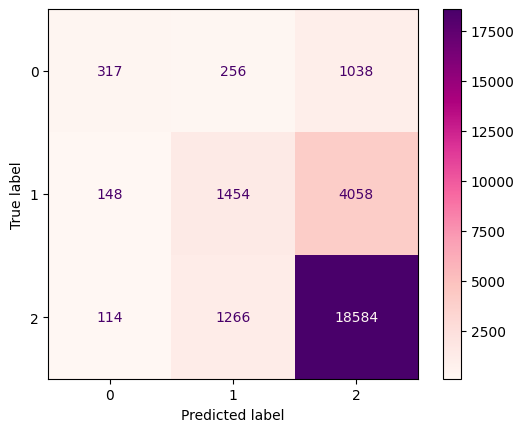

In [32]:
cm = confusion_matrix(y_test_3, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.RdPu)
cm_display

In [ ]:
y_train_pred = model.predict(X_train_3)

In [ ]:
print('Accuracy:', accuracy_score(y_train_3, y_train_pred))
print('Precision:', precision_score(y_train_3, y_train_pred, average='weighted'))
print('Recall:', recall_score(y_train_3, y_train_pred, average='weighted'))
print('F1-score:', f1_score(y_train_3, y_train_pred, average='weighted'))

Accuracy: 0.8005434383491224
Precision: 0.8256744130022092
Recall: 0.8005434383491224
F1-score: 0.7562186049613491


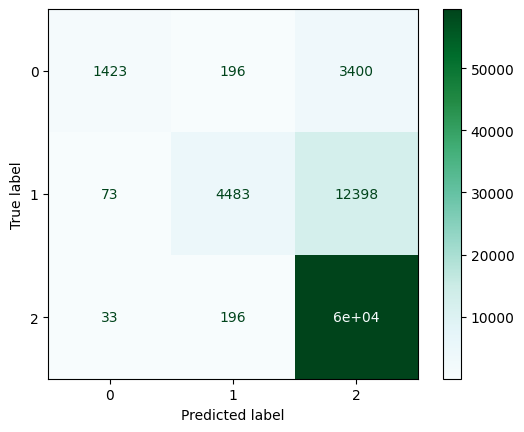

In [ ]:
cm = confusion_matrix(y_train_3, y_train_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.BuGn)
cm_display

### More classes

<AxesSubplot: ylabel='Frequency'>

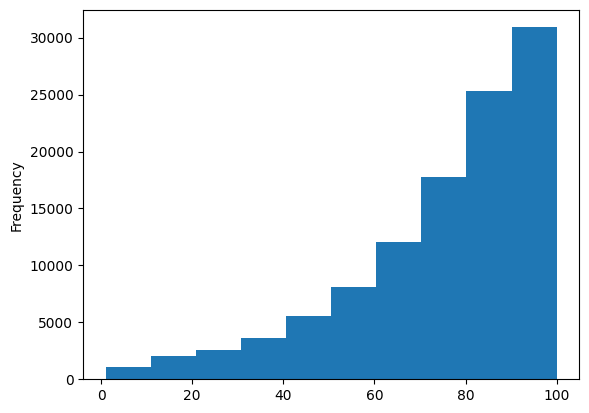

In [35]:
df['yield_value'].plot.hist()

In [43]:
df['yield_value'].sort_values().iloc[(df.shape[0] // 5)*4]

94

In [44]:
def get_yield_class(y):
    if y <= 60:
        c = 0 #low
    elif y > 60 and y <= 76:
        c = 1 #medium
    elif y > 76 and y <= 86:
        c = 2 #medium
    elif y > 86 and y <= 94:
        c = 3 #medium
    elif y > 94:
        c = 4 #high
    return c

In [45]:
df_new['yield_value'] = df['yield_value'].apply(get_yield_class).to_frame().set_index(df.index)

In [46]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(reactions_fp, df_new['yield_value'], test_size=0.25, random_state=42, shuffle=True)

In [47]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_2, y_train_2, test_size=0.25, random_state=42, shuffle=True)

In [50]:
def objective_2(trial):
    """Define the objective function"""

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**param)
    optuna_model.fit(X_train_1, y_train_1)

    # Make predictions
    y_pred = optuna_model.predict(X_val_1)

    # Evaluate predictions
    return f1_score(y_val_1, y_pred, average='weighted')

In [51]:
study_class_2 = optuna.create_study(direction="maximize", study_name='classification')
study_class_2.optimize(objective_2, n_trials=30)

[I 2023-04-04 16:27:59,023] A new study created in memory with name: classification
[I 2023-04-04 16:28:45,481] Trial 0 finished with value: 0.31065496118272473 and parameters: {'max_depth': 4, 'learning_rate': 0.4538355020097123, 'n_estimators': 71, 'min_child_weight': 1, 'gamma': 0.3586705340293446, 'subsample': 0.7735514941562469, 'colsample_bytree': 0.8830813020482293, 'reg_alpha': 0.5213798273698617, 'reg_lambda': 0.6384200809321942, 'random_state': 919}. Best is trial 0 with value: 0.31065496118272473.
[I 2023-04-04 16:37:06,837] Trial 1 finished with value: 0.32584512878707783 and parameters: {'max_depth': 8, 'learning_rate': 0.9557296199237134, 'n_estimators': 544, 'min_child_weight': 7, 'gamma': 0.694487873745383, 'subsample': 0.2684949308095442, 'colsample_bytree': 0.8081200392070207, 'reg_alpha': 0.8105569054779684, 'reg_lambda': 0.0653664853250797, 'random_state': 562}. Best is trial 1 with value: 0.32584512878707783.
[I 2023-04-04 16:38:13,816] Trial 2 finished with value:

[I 2023-04-04 19:00:33,748] Trial 19 finished with value: 0.35522337220580225 and parameters: {'max_depth': 7, 'learning_rate': 0.18183210691681057, 'n_estimators': 650, 'min_child_weight': 4, 'gamma': 0.8087298102960725, 'subsample': 0.6187993679472736, 'colsample_bytree': 0.7242488239223421, 'reg_alpha': 0.7341961581466766, 'reg_lambda': 0.33632593134188254, 'random_state': 619}. Best is trial 6 with value: 0.35927063383049956.
[I 2023-04-04 19:03:35,575] Trial 20 finished with value: 0.3416481625188292 and parameters: {'max_depth': 9, 'learning_rate': 0.3982742158971907, 'n_estimators': 191, 'min_child_weight': 7, 'gamma': 0.5603325069622054, 'subsample': 0.4067941626664596, 'colsample_bytree': 0.568007422353952, 'reg_alpha': 0.8951354645063136, 'reg_lambda': 0.5697205512379482, 'random_state': 841}. Best is trial 6 with value: 0.35927063383049956.
[I 2023-04-04 19:18:17,742] Trial 21 finished with value: 0.35888803812274944 and parameters: {'max_depth': 7, 'learning_rate': 0.163707

In [52]:
study_class_2.best_params

{'max_depth': 9,
 'learning_rate': 0.09986183887426114,
 'n_estimators': 496,
 'min_child_weight': 2,
 'gamma': 0.42768767909444233,
 'subsample': 0.6874024615123444,
 'colsample_bytree': 0.8841174273940635,
 'reg_alpha': 0.6238666918176015,
 'reg_lambda': 0.8721403544025372,
 'random_state': 889}

In [53]:
model = xgb.XGBClassifier(**study_class.best_params)
model.fit(X_train_2, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5758930838144295, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6032025633673059, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2894189303719569, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=483, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [54]:
y_test_pred = model.predict(X_test_2)

In [55]:
print('Accuracy:', accuracy_score(y_test_2, y_test_pred))
print('Precision:', precision_score(y_test_2, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test_2, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test_2, y_test_pred, average='weighted'))

Accuracy: 0.37818982926381495
Precision: 0.3750531547208717
Recall: 0.37818982926381495
F1-score: 0.3755492704392754


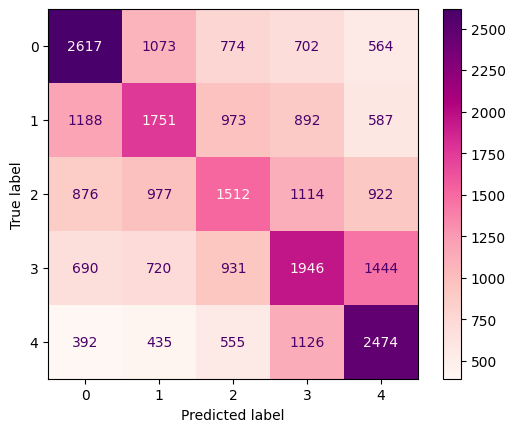

In [56]:
cm = confusion_matrix(y_test_2, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.RdPu)
cm_display